In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download Dataset

In [ ]:
import os

data_dir = '/content/drive/MyDrive/Hung/Assignment-2/cifar10_data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

os.chdir(data_dir)
cifar10_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
!wget {cifar10_url}

--2025-05-17 07:21:53--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  28.4MB/s    in 5.6s    

2025-05-17 07:21:58 (28.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



## Unzip

In [ ]:
import tarfile

file_ =  "/content/drive/MyDrive/Hung/Assignment-2/cifar10_data/cifar-10-python.tar.gz"
with tarfile.open(file_, "r:gz") as tar:
  tar.extractall()
  print("Complete unzipping!")


Complete unzipping!


## Load CIFAR-10

In [ ]:
import pickle
import numpy as np
import os

def load_cifar10_batch(file_path):
  with open(file_path, 'rb') as fo:
    batch_dict = pickle.load(fo, encoding='latin1')
  return batch_dict

def load_cifar10_data(data_folder_path):
  train_data = []
  train_labels = []
  for i in range(1,6):
    file_path = os.path.join(data_folder_path, f"data_batch_{i}")
    batch_dict = load_cifar10_batch(file_path)
    train_data.append(batch_dict['data'])
    train_labels.append(batch_dict['labels'])
  X_train = np.concatenate(train_data)
  X_train = X_train.reshape((len(X_train), 3, 32, 32)).transpose(0, 2, 3, 1)
  y_train = np.array(train_labels)

  test_file_path = os.path.join(data_folder_path, 'test_batch')
  test_batch_dict = load_cifar10_batch(test_file_path)
  X_test = test_batch_dict['data']
  X_test = X_test.reshape((len(X_test), 3, 32, 32)).transpose(0, 2, 3, 1)
  y_test = np.array(test_batch_dict['labels'])

  meta_file_path = os.path.join(data_folder_path, 'batches.meta')
  with open(meta_file_path, 'rb') as fo:
      meta_dict = pickle.load(fo, encoding='latin1')
  label_names = meta_dict['label_names']

  return X_train, y_train, X_test, y_test, label_names


In [ ]:
cifar_batches_dir = "/content/drive/MyDrive/Hung/Assignment-2/cifar10_data/cifar-10-batches-py"

if os.path.exists(cifar_batches_dir):
  X_train, y_train, X_test, y_test, label_names = load_cifar10_data(cifar_batches_dir)


## Create data_loader file

In [ ]:
%%writefile /content/drive/MyDrive/Hung/Assignment-2/Source_code_MobileNetV2/data_loader_4MBN.py
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from PIL import Image

def load_cifar10_batch(file_path):
  with open(file_path, 'rb') as fo:
    batch_dict = pickle.load(fo, encoding='latin1')
  return batch_dict

def load_cifar10_data(data_folder_path):
  train_data = []
  train_labels = []
  for i in range(1,6):
    file_path = os.path.join(data_folder_path, f"data_batch_{i}")
    batch_dict = load_cifar10_batch(file_path)
    train_data.append(batch_dict['data'])
    train_labels.extend(batch_dict['labels'])

  X_train_raw = np.concatenate(train_data)
  X_train_reshaped = X_train_raw.reshape((len(X_train_raw), 3, 32, 32))
  X_train = X_train_reshaped.transpose(0, 2, 3, 1)
  y_train = np.array(train_labels)

  test_file_path = os.path.join(data_folder_path, 'test_batch')
  test_batch_dict = load_cifar10_batch(test_file_path)
  X_test_raw = test_batch_dict['data']
  X_test_reshaped = X_test_raw.reshape((len(X_test_raw), 3, 32, 32))
  X_test = X_test_reshaped.transpose(0, 2, 3, 1)
  y_test = np.array(test_batch_dict['labels'])

  label_names = []
  meta_file_path = "/content/drive/MyDrive/Hung/Assignment-2/cifar10_data/cifar-10-batches-py/batches.meta"
  with open(meta_file_path, 'rb') as fo:
      meta_dict = pickle.load(fo, encoding='latin1')
  label_names = meta_dict.get('label_names', [])


  return X_train, y_train, X_test, y_test, label_names

class Custom_Dataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args </>
          data (numpy.ndarray): Image, expected in format (N, H, W, C).
          targets (numpy.ndarray): Labels for data (1D array).
          transform (callable, optional): A function/transform to apply to each sample.
        """

        if not (data.ndim == 4 and data.shape[1] == 32 and data.shape[2] == 32 and data.shape[3] == 3):
            raise ValueError(f"Image data is not in correct format (N, H, W, C). Actual shape: {data.shape}")

        self.data = data
        self.targets = torch.tensor(targets, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_np = self.data[idx]
        label = self.targets[idx]

        if self.transform:
            image = self.transform(image_np)
        else:
            image = torch.tensor(image_np.transpose(2,0,1), dtype=torch.float32) / 255.0

        return image, label


def get_cifar_transforms(img_size=32, is_train=True):

    normalize_transform = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]) # CIFAR-10

    if is_train:
        transform_list = [
            transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            normalize_transform
        ]
    else:
        transform_list = [
            transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            normalize_transform
        ]
    return transforms.Compose(transform_list)

def get_cifar_dataloaders(cifar_batches_path, batch_size, img_size, num_workers=2, shuffle_train=True, validation_split_ratio=0.2, random_seed=42):

    X_train, y_train, X_test, y_test, lb_name = load_cifar10_data(cifar_batches_path)
    print(f"Loaded X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Loaded X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    X_train_new, X_val, y_train_new, y_val = None, None, None, None
    val_loader = None

    X_train_new, X_val, y_train_new, y_val = train_test_split(
            X_train,
            y_train,
            test_size=validation_split_ratio,
            random_state=random_seed,
            stratify=y_train
        )

    train_transforms = get_cifar_transforms(img_size=img_size, is_train=True)
    val_transforms = get_cifar_transforms(img_size=img_size, is_train=False)
    test_transforms = get_cifar_transforms(img_size=img_size, is_train=False)

    train_dataset = Custom_Dataset(data=X_train_new, targets=y_train_new, transform=train_transforms)
    test_dataset = Custom_Dataset(data=X_test, targets=y_test, transform=test_transforms)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=shuffle_train,
        num_workers=num_workers,
        pin_memory=True
    )

    if X_val is not None and y_val is not None:
        val_dataset = Custom_Dataset(data=X_val, targets=y_val, transform=val_transforms)
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    print(f"Created Train DataLoader with {len(train_dataset)} samples, Test DataLoader with {len(test_dataset)} samples.")
    return train_loader, val_loader, test_loader, lb_name


if __name__ == "__main__":
    cifar_data_path = "/content/drive/MyDrive/Hung/Assignment-2/cifar10_data/cifar-10-batches-py"

    BATCH_SIZE = 16
    IMG_SIZE_FOR_MODEL = 224

    print(f"\nCreating dataloader with batch_size={BATCH_SIZE}, img_size={IMG_SIZE_FOR_MODEL}...")

    train_loader, val_loader, test_loader, _ = get_cifar_dataloaders(
        cifar_batches_path=cifar_data_path,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE_FOR_MODEL
    )
    if val_loader is not None:
        images_val_batch, labels_val_batch = next(iter(val_loader))
        print(f"Shape of validation batch: {images_val_batch.shape}")
        print(f"Shape of validation batch: {labels_val_batch.shape}")
        print(f"Datatype of validation: {images_val_batch.dtype}")

# Made by Hung-dev-guy </>


Overwriting /content/drive/MyDrive/Hung/Assignment-2/Source_code_MobileNetV2/data_loader_4MBN.py


In [ ]:
!python /content/drive/MyDrive/Hung/Assignment-2/Source_code_MobileNetV2/data_loader_4MBN.py


Creating dataloader with batch_size=16, img_size=224...
Loaded X_train shape: (50000, 32, 32, 3), y_train shape: (50000,)
Loaded X_test shape: (10000, 32, 32, 3), y_test shape: (10000,)
Created Train DataLoader with 40000 samples, Test DataLoader with 10000 samples.
Shape of validation batch: torch.Size([16, 3, 224, 224])
Shape of validation batch: torch.Size([16])
Datatype of validation: torch.float32


In [ ]:
%%writefile /content/drive/MyDrive/Hung/Assignment-2/Source_code_MobileNetV2/MobileNetV2_model.py
import torch
import torch.nn as nn
import math

num_classes = 10
input_size = 224
width_mult=1.0
classifier_dropout_rate=0.1
round_nearest=8
norm_layer=nn.BatchNorm2d

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1, norm_layer=None):
        padding = (kernel_size - 1) // 2
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU6(inplace=True)
        )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, norm_layer=None):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup # Điều kiện cho kết nối tắt (shortcut)

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))

        layers.extend([
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x) # Kết nối tắt
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, num_classes=10, width_mult=1.0, round_nearest=8, norm_layer=nn.BatchNorm2d, input_size=224, classifier_dropout_rate=0.1):
        super(MobileNetV2, self).__init__()

        input_channel = 32
        last_channel = 1280 # Number of channels before classifier

        # Details of inverted residual blocks: [t, c, n, s]
        # t: expansion factor
        # c: output channels
        # n: number of repetition
        # s: stride for the first repetition of block
        inverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        first_layer_stride = 2

        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)

        features = [ConvBNReLU(3, input_channel, stride=first_layer_stride, norm_layer=norm_layer)]

        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel #

        # last layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        self.features = nn.Sequential(*features)

        # Adaptive Average Pooling and Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def mobilenet_v2_scratch(num_classes=10, width_mult=1.0, round_nearest=8, norm_layer=nn.BatchNorm2d, input_size=224, classifier_dropout_rate=0.1):
    model = MobileNetV2(
            num_classes=num_classes,
            width_mult=width_mult,
            round_nearest=round_nearest,
            norm_layer=norm_layer,
            input_size=input_size,
            classifier_dropout_rate=classifier_dropout_rate,
        )
    return model



Overwriting /content/drive/MyDrive/Hung/Assignment-2/Source_code_MobileNetV2/MobileNetV2_model.py


In [ ]:
!python /content/drive/MyDrive/Hung/Assignment-2/Source_code_MobileNetV2/MobileNetV2_model.py

## Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys

from google.colab import drive
drive.mount('/content/drive')

module_path = '/content/drive/MyDrive/Hung/Assignment-2/Source_code_MobileNetV2'
if module_path not in sys.path:
    sys.path.append(module_path)

from MobileNetV2_model import mobilenet_v2_scratch
from data_loader_4MBN import get_cifar_dataloaders

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Use {DEVICE}")

CIFAR_DATA_PATH = "/content/drive/MyDrive/Hung/Assignment-2/cifar10_data/cifar-10-batches-py"

NUM_CLASSES = 10
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 25

Use cuda


In [ ]:
print(f"\Preparing dataLoader with img_size={IMG_SIZE}, batch_size={BATCH_SIZE}...")

train_loader, val_loader, test_loader, _ = get_cifar_dataloaders(
    cifar_batches_path=CIFAR_DATA_PATH,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    num_workers=2
)


\Preparing dataLoader with img_size=224, batch_size=32...
Loaded X_train shape: (50000, 32, 32, 3), y_train shape: (50000,)
Loaded X_test shape: (10000, 32, 32, 3), y_test shape: (10000,)
Created Train DataLoader with 40000 samples, Test DataLoader with 10000 samples.


In [ ]:
print(f"\nInitializing MobileNetV2 with num_classes={NUM_CLASSES}, input_size={IMG_SIZE}...")
model = mobilenet_v2_scratch(num_classes=NUM_CLASSES, input_size=IMG_SIZE, width_mult=1.0)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)


Initializing MobileNetV2 with num_classes=10, input_size=224...


In [ ]:
history_train_loss = []
history_train_acc = []
history_val_loss = []
history_val_acc = []

In [ ]:
import time
print("\nBegin training process...")
for epoch in range(NUM_EPOCHS):
    start_time_epoch = time.time()
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_train
    epoch_acc = 100. * correct_train / total_train
    history_train_loss.append(epoch_loss)
    history_train_acc.append(epoch_acc)

    # Evaluate on validation set
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    epoch_val_loss = running_val_loss / total_val
    epoch_val_accuracy = 100 * correct_val / total_val
    history_val_loss.append(epoch_val_loss)
    history_val_acc.append(epoch_val_accuracy)

    end_time_epoch = time.time()
    epoch_duration = end_time_epoch - start_time_epoch

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - {epoch_duration:.2f}s - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% - "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")



Begin training process...
Epoch [1/25] - 153.44s - Train Loss: 1.4976, Train Acc: 45.13% - Val Loss: 1.0985, Val Acc: 60.99%
Epoch [2/25] - 153.85s - Train Loss: 1.0329, Train Acc: 63.59% - Val Loss: 0.8299, Val Acc: 70.71%
Epoch [3/25] - 152.00s - Train Loss: 0.8367, Train Acc: 71.06% - Val Loss: 0.7310, Val Acc: 74.57%
Epoch [4/25] - 151.72s - Train Loss: 0.7301, Train Acc: 74.81% - Val Loss: 0.6430, Val Acc: 77.86%
Epoch [5/25] - 152.27s - Train Loss: 0.6566, Train Acc: 77.47% - Val Loss: 0.5910, Val Acc: 79.89%
Epoch [6/25] - 153.70s - Train Loss: 0.6061, Train Acc: 79.17% - Val Loss: 0.6137, Val Acc: 79.18%
Epoch [7/25] - 152.39s - Train Loss: 0.5658, Train Acc: 80.68% - Val Loss: 0.5944, Val Acc: 79.31%
Epoch [8/25] - 154.58s - Train Loss: 0.5302, Train Acc: 81.84% - Val Loss: 0.4746, Val Acc: 83.58%
Epoch [9/25] - 152.75s - Train Loss: 0.4916, Train Acc: 83.13% - Val Loss: 0.5019, Val Acc: 82.95%
Epoch [10/25] - 153.25s - Train Loss: 0.4597, Train Acc: 84.10% - Val Loss: 0.4769

## Save model

In [ ]:
size = len(os.listdir("/content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run"))
next_order = size + 1
os.mkdir(f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_{next_order}")

PATH_TO_SAVE_MODEL = f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_{next_order}/mobilenetv2_try{next_order}.pth"
torch.save(model.state_dict(), PATH_TO_SAVE_MODEL)
print(f"Model saved to: {PATH_TO_SAVE_MODEL}")

training_history = {
    'train_losses': history_train_loss,
    'val_losses': history_val_loss,
    'train_accuracies': history_train_acc,
    'val_accuracies': history_val_acc
}
history = f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_{next_order}/train_hist_{next_order}.pth"
torch.save(training_history, history)
print(f"Training history saved to: {history}")

hyper_para = {
    'dropout_rate': 0.1,
    'learning_rate': LEARNING_RATE,
    'epochs_trained': NUM_EPOCHS,
    'weight_decay': 1e-5
}
location = f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_{next_order}/hyperpara_{next_order}.pth"
torch.save(hyper_para, location)
print(f"Training history saved to: {location}")

Model saved to: /content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_4/mobilenetv2_try4.pth
Training history saved to: /content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_4/train_hist_4.pth
Training history saved to: /content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_4/hyperpara_4.pth


## Plot Learning Curve

In [ ]:
next_order = 4

Sample loaded train loss (first 5 epochs): [1.4976376080989837, 1.0328947750091553, 0.83665890853405, 0.7301260564804077, 0.6565836379051209]


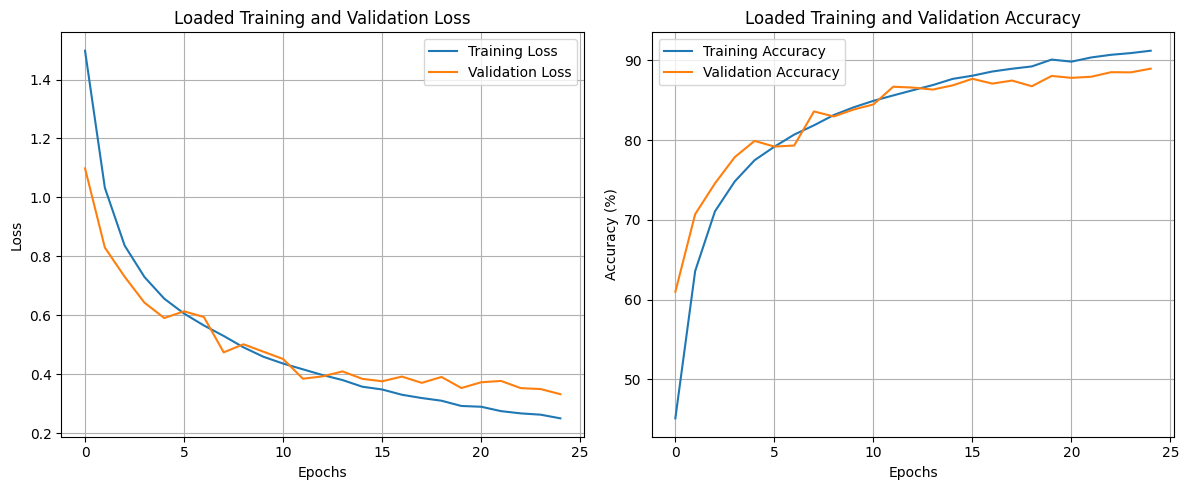

In [ ]:
import torch
import matplotlib.pyplot as plt

HISTORY_PATH = f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_{next_order}/train_hist_{next_order}.pth"

loaded_history = torch.load(HISTORY_PATH)
loaded_train_losses = loaded_history['train_losses']
loaded_val_losses = loaded_history['val_losses']
loaded_train_accuracies = loaded_history['train_accuracies']
loaded_val_accuracies = loaded_history['val_accuracies']


print("Sample loaded train loss (first 5 epochs):", loaded_train_losses[:5])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loaded_train_losses, label='Training Loss')
plt.plot(loaded_val_losses, label='Validation Loss')
plt.title('Loaded Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loaded_train_accuracies, label='Training Accuracy')
plt.plot(loaded_val_accuracies, label='Validation Accuracy')
plt.title('Loaded Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Plot Confusion Matrix

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive')

module_path = '/content/drive/MyDrive/Hung/Assignment-2/Source_code_MobileNetV2'
if module_path not in sys.path:
    sys.path.append(module_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.metrics import confusion_matrix
from MobileNetV2_model import mobilenet_v2_scratch
from data_loader_4MBN import get_cifar_dataloaders
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import os


In [ ]:
PATH_TO_SAVED_MODEL = f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_{next_order}/mobilenetv2_try{next_order}.pth"
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(cifar10_classes)
loaded_model = mobilenet_v2_scratch(
                num_classes = 10,
                input_size = 224,
                width_mult=1.0,
                classifier_dropout_rate=0.1,
                round_nearest=8,
                norm_layer=nn.BatchNorm2d,
              )
loaded_model.load_state_dict(torch.load(PATH_TO_SAVED_MODEL))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model.to(device)
loaded_model.eval()

all_labels = []
all_predictions = []

cifar_data_path = "/content/drive/MyDrive/Hung/Assignment-2/cifar10_data/cifar-10-batches-py"
BATCH_SIZE = 32
IMG_SIZE_FOR_MODEL = 224

train_loader, val_loader, test_loader, label_names = get_cifar_dataloaders(
      cifar_batches_path=cifar_data_path,
      batch_size=BATCH_SIZE,
      img_size=IMG_SIZE_FOR_MODEL
)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = loaded_model(inputs)
        _, predicted_classes = torch.max(outputs, 1)

        all_predictions.extend(predicted_classes.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Loaded X_train shape: (50000, 32, 32, 3), y_train shape: (50000,)
Loaded X_test shape: (10000, 32, 32, 3), y_test shape: (10000,)
Created Train DataLoader with 40000 samples, Test DataLoader with 10000 samples.


Confusion matrix saved to: /content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_4/confusion_matrix_4.png


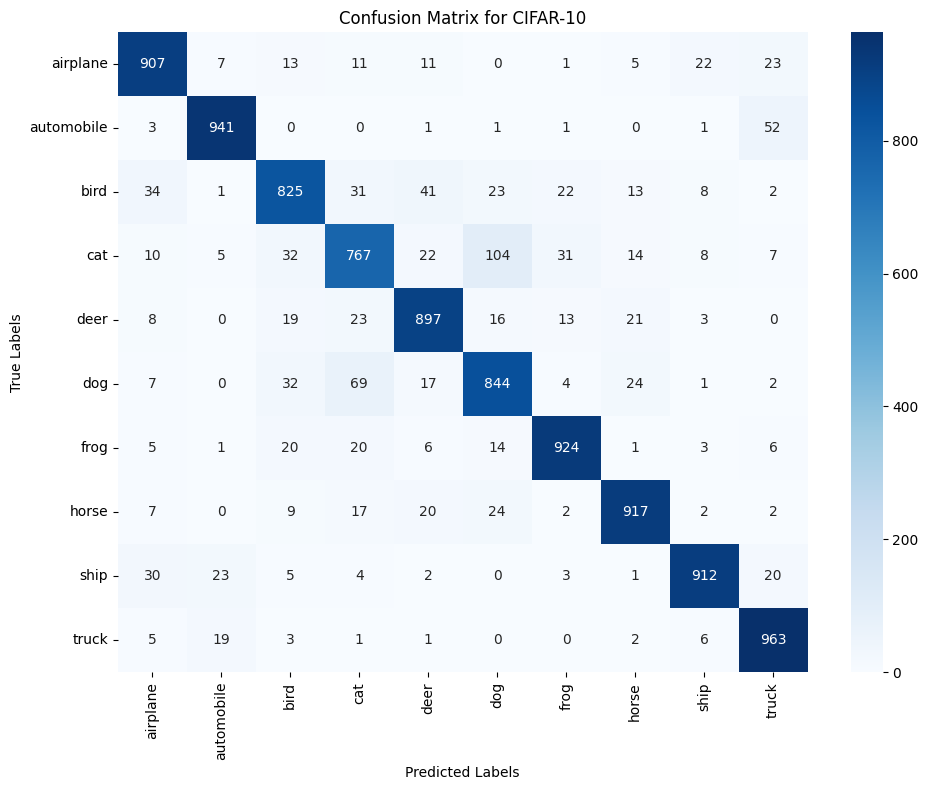

In [ ]:
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CIFAR-10')

plt.tight_layout()
cm_fname = f"confusion_matrix_{next_order}.png"
cm_save_path = os.path.join(f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_{next_order}", cm_fname)
plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix saved to: {cm_save_path}")

plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("-" * 50)
print("Classification Report:")
print("-" * 50)
report_str = classification_report(all_labels, all_predictions, target_names=cifar10_classes, digits=2)
print(report_str)

report_filename = "classification_report.txt"
report_save_path = os.path.join(f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_{next_order}", report_filename)

with open(report_save_path, 'w', encoding='utf-8') as f:
    f.write("========= Classification Report =========\n")
    f.write("=" * 40 + "\n\n")
    f.write(report_str)
print(f"Classification report saved to: {report_save_path}")

--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

    airplane       0.89      0.91      0.90      1000
  automobile       0.94      0.94      0.94      1000
        bird       0.86      0.82      0.84      1000
         cat       0.81      0.77      0.79      1000
        deer       0.88      0.90      0.89      1000
         dog       0.82      0.84      0.83      1000
        frog       0.92      0.92      0.92      1000
       horse       0.92      0.92      0.92      1000
        ship       0.94      0.91      0.93      1000
       truck       0.89      0.96      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Classification report saved to: /content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_4/cla

## Accuracies Performance

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
def get_accuracy(model, data_loader, device):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    all_labels_list = []
    all_predictions_list = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted_classes = torch.max(outputs, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted_classes == labels).sum().item()

            all_predictions_list.extend(predicted_classes.cpu().numpy())
            all_labels_list.extend(labels.cpu().numpy())

    if total_samples == 0:
        return 0.0, [], []

    accuracy = 100. * correct_predictions / total_samples
    return accuracy, all_labels_list, all_predictions_list



In [ ]:
print("\n--- Calculating Final Accuracies ---")

final_train_accuracy, _, _ = get_accuracy(loaded_model, train_loader, DEVICE)
print(f"Final Accuracy on Training Set: {final_train_accuracy:.2f}%")

final_val_accuracy, val_labels, val_preds = get_accuracy(loaded_model, val_loader, DEVICE)
print(f"Final Accuracy on Validation Set: {final_val_accuracy:.2f}%")

final_test_accuracy, test_labels, test_preds = get_accuracy(loaded_model, test_loader, DEVICE)
print(f"Final Accuracy on Test Set: {final_test_accuracy:.2f}%")


--- Calculating Final Accuracies ---
Final Accuracy on Training Set: 93.77%
Final Accuracy on Validation Set: 88.94%
Final Accuracy on Test Set: 88.97%


In [ ]:
Acr = "Accuracies.txt"
Acr_path = os.path.join(f"/content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_{next_order}", Acr)

with open(Acr_path, 'w', encoding='utf-8') as f:
    f.write("========= Accuracies Report =========\n")
    f.write("=" * 40 + "\n")
    f.write(f"- Final Accuracy on Training Set: {final_train_accuracy:.2f}%")
    f.write(f"\n- Final Accuracy on Validation Set: {final_val_accuracy:.2f}%")
    f.write(f"\n- Final Accuracy on Test Set: {final_test_accuracy:.2f}%")
print(f"Accuracies report saved to: {Acr_path}")

Accuracies report saved to: /content/drive/MyDrive/Hung/Assignment-2/Experiments/MobileNetV2_cifar_run/Try_4/Accuracies.txt
